# Exercise 6: AR-GARCH models

**_Group: Ducray, Razanajatovo_**

Please find below our code and empirical work regarding Apple's price returns. To fit the AR+GARCH model, we will fit first the AR(p) model and then applying the GARCH model to the residuals. The final prediction will be the sum of the ARIMA forecast + the GARCH forecasts.

In [1]:
# Dataframe, maths and plotting libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm


from statsmodels.tsa.stattools import adfuller
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

!pip install arch
from arch import arch_model

In [3]:
#============== Load and prepare data ================

    # Import data
df = pd.read_excel('AAPL.xlsx',index_col=0)
    # Sort data in chronological order
df = df.sort_values(by='Date', ascending=True)
    # Compute the daily log returns on Roche stock prices
df_logret = np.log(df['Adj Close'].iloc[1:]).diff().dropna()*100
df_logret

Date
2018-01-04    0.463396
2018-01-05    1.132147
2018-01-08   -0.372139
2018-01-09   -0.011468
2018-01-10   -0.022940
                ...   
2022-08-24    0.179230
2022-08-25    1.481248
2022-08-26   -3.842832
2022-08-29   -1.378469
2022-08-30   -1.542384
Name: Adj Close, Length: 1172, dtype: float64

Text(0, 0.5, 'Log-Return')

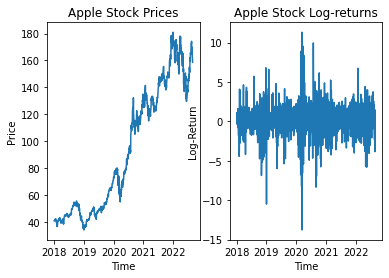

In [4]:
#================== Visual representation ===================

# Check the stock price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Adj Close'])
plt.title("Apple Stock Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_logret)
plt.title("Apple Stock Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')

1. Checking the stationarity with the Augmented Dickey Fuller test which test for the presence of a unit root:

In [5]:
test = adfuller(df_logret)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

,Output
Test Statistic Value,-10.679321
p-value,0.0
Lags Used,8
Number of Observations Used,1163
Critical Value(1%),-3.435985
Critical Value(5%),-2.864028
Critical Value(10%),-2.568095


The null hypothesis is rejected: the process is **stationary** (pvalue below thresholds & t-stat < critical value)
No need to differentiate or detrend

2. Fitting AR and GARCH models:

Splitting dataset in train and test sets with a ratio of 70:30

In [6]:
df_train = df_logret.iloc[:round(len(df_logret)*0.7)]
df_test = df_logret.iloc[round(len(df_logret)*0.7):]

C:\Users\arian\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


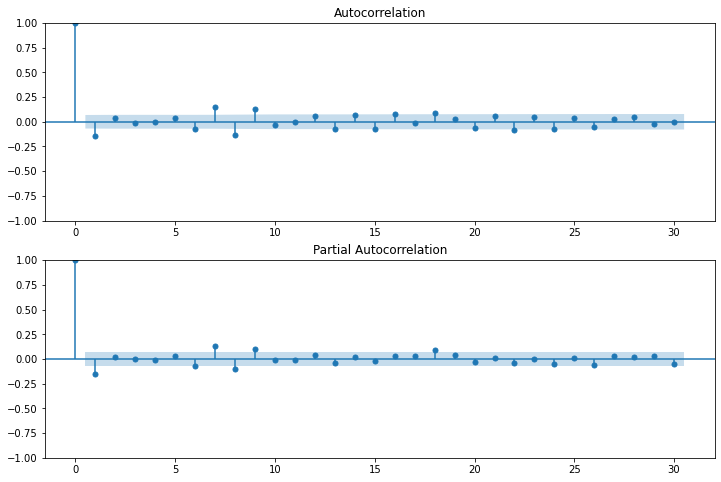

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=30, ax=ax2)

Graphically, we can't conclude about the exponential decay of the ACF but we can see a spike at order 1 on the PACF. We will use AIC and BIC criterion to confirm the optimal parameters:

In [10]:
from itertools import product
ar_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ma_order = [0]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]
#     pprint.pprint(arma_res)

for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, 0)).fit()
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 - ma:0
fitting: ar:1 - ma:0
fitting: ar:2 - ma:0


C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

fitting: ar:3 - ma:0
fitting: ar:4 - ma:0


C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

fitting: ar:5 - ma:0
fitting: ar:6 - ma:0


C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

fitting: ar:7 - ma:0


C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


fitting: ar:8 - ma:0


C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


fitting: ar:9 - ma:0


C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


fitting: ar:10 - ma:0


C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\arian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


criterion
     ar_order  ma_order       aic       bic
0          0         0  3.625207  3.634626
1          1         0  3.609156  3.623284
2          2         0  3.610959  3.629796
3          3         0  3.612959  3.636506
4          4         0  3.614926  3.643181
5          5         0  3.616023  3.648988
6          6         0  3.614119  3.651794
7          7         0  3.602049  3.644433
8          8         0  3.595866  3.642959
9          9         0  3.589276  3.641078
10        10         0  3.591251  3.647763


In [11]:
#========= confirming order chosen ============
sm.tsa.arma_order_select_ic(df_train,max_ar=10,max_ma=0,ic='bic')['bic_min_order']

(1, 0)

**The order chosen is thus an AR(1) to fit the data**

Now to detect the GARCH effect:
    a. First we construct the standardized residuals and run a normality test on them (Jarque-Bera test):

In [29]:
df_train_std = (df_train - np.mean(df_train))/ np.std(df_train)
nb_obs = len(df_train)

jb = sm.stats.stattools.jarque_bera(df_train_std, axis=0)
print(jb)

mw_size = 250
jb_mw = np.zeros(nb_obs-mw_size)
for x in range(0, nb_obs-mw_size):
    jb =  sm.stats.stattools.jarque_bera(df_train_std[x:mw_size+x], axis=0)  
    jb_mw [x] = jb[1]
    
np.mean(jb_mw < 0.05)

(1058.677717123933, 1.2913818242588948e-230, -0.35332055700700343, 8.521444341624855)


1.0

This Jarque-Bera test is a goodness-of-fit test that returns the JB t-stat, p-value, skewness and the kurtosis. Clearly **we can reject the null hypothesis of a normal distribution** (p-value being above any threshold) and confirm a GARCH effect. One could use a different distribution for GARCH, one with fatter tails and that takes into account the skewness.

Iteration:      1,   Func. Count:      7,   Neg. LLF: 47335.403056261755
Iteration:      2,   Func. Count:     16,   Neg. LLF: 22307.180233455823
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1862.0838048745675
Iteration:      4,   Func. Count:     32,   Neg. LLF: 2050.791818043996
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1696.4156058140297
Iteration:      6,   Func. Count:     46,   Neg. LLF: 1037.232837274403
Iteration:      7,   Func. Count:     53,   Neg. LLF: 1017.3951000105619
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1017.291737149986
Iteration:      9,   Func. Count:     65,   Neg. LLF: 1017.2711685096358
Iteration:     10,   Func. Count:     71,   Neg. LLF: 1017.256160103186
Iteration:     11,   Func. Count:     77,   Neg. LLF: 1017.2528081842195
Iteration:     12,   Func. Count:     83,   Neg. LLF: 1017.2521549570648
Iteration:     13,   Func. Count:     89,   Neg. LLF: 1017.2520604307496
Iteration:     14,   Func. Count:     95,   Neg. LLF: 1

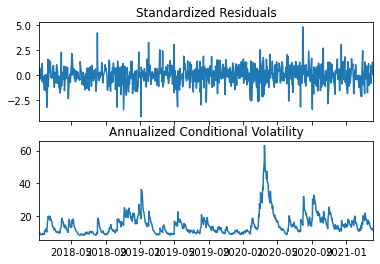

In [30]:
#======= GARCH(1,1) estimates =====================================

am = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
# by putting o=1 you can model leverage effects => GJR-GARCH(1,1) model
res = am.fit()
print(res.summary())
fig = res.plot(annualize='D')

In [34]:
from scipy.stats import t
print(t.ppf(0.05,9.4548))
print(norm.ppf(0.05))

-1.8231245366836821
-1.6448536269514729


0.49146341463414633
0.4878048780487805
0.4841463414634146


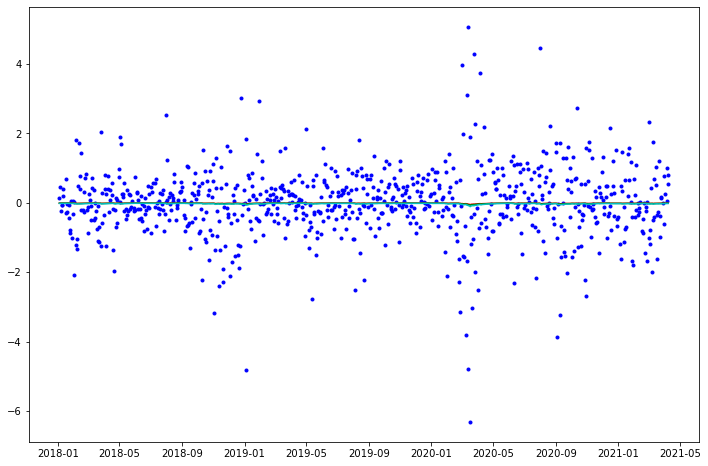

In [35]:
#================== Value-at-Risk estimates=================

temp = res.conditional_volatility
var90 = (0.0656 + res.conditional_volatility * t.ppf(0.10,9.2571)) /100
var95 = (0.0656 + res.conditional_volatility * t.ppf(0.05,9.2571)) /100
var99 = (0.0656 + res.conditional_volatility * t.ppf(0.01,9.2571)) /100
    
fig = plt.figure(figsize=(12,8))
plt.plot(df_train_std, 'b.', var90, 'r-', var95, 'g-', var99, 'c-')
 
print(np.mean(df_train_std < var90))  
print(np.mean(df_train_std < var95)) 
print(np.mean(df_train_std < var99))